In [39]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xarray as xr
import pandas as pd
from glob import glob
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Merge, Dense, Activation, Input, Reshape, LeakyReLU, Flatten, merge
from keras.layers import Concatenate, concatenate
import tensorflow as tf
from deepsky.gan import stack_gen_encoder, unscale_multivariate_data, rescale_multivariate_data
import keras.backend.tensorflow_backend as K
from os.path import join
import matplotlib.colors as colors
from keras.utils import plot_model
from IPython.display import Image
import os
import tensorflow as tf

In [50]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
session = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=True,
                                                               gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                               log_device_placement=False))
K.set_session(session)

In [2]:

def generator_model(input_size=100, filter_width=5, min_data_width=4,
                    min_conv_filters=64, output_size=(32, 32, 1), stride=2):
    """
    Creates a generator convolutional neural network for a generative adversarial network set. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (int): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the first convolved layer after the input layer
        min_conv_filters (int): Number of convolutional filters in the last convolutional layer
        output_size (tuple of size 3): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(output_size[0]) - np.log2(min_data_width))
    max_conv_filters = int(min_conv_filters * 2 ** (num_layers - 1))
    curr_conv_filters = max_conv_filters
    vector_input = Input(shape=(input_size, ), name="gen_input")
    model = Dense(input_shape=(input_size,), units=max_conv_filters * min_data_width * min_data_width)(vector_input)
    model = Reshape((min_data_width, min_data_width, max_conv_filters))(model)
    model = Activation("relu")(model)
    for i in range(1, num_layers):
        curr_conv_filters //= 2
        model = Conv2DTranspose(curr_conv_filters, filter_width,
                                  strides=(stride, stride), padding="same")(model)
        model = Activation("relu")(model)
    model = Conv2DTranspose(output_size[-1], filter_width,
                              strides=(stride, stride),
                              padding="same")(model)
    model = Activation("tanh")(model)
    return model, vector_input

def encoder_model(input_size=(32, 32, 1), filter_width=5, min_data_width=4,
                    min_conv_filters=64, output_size=100, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="enc_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, filter_width,
                           input_shape=input_size,
                           strides=(stride, stride), padding="same")(image_input)
        else:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same")(model)
        model = Activation("relu")(model)
        curr_conv_filters *= 2
    model = Flatten()(model)
    model = Dense(output_size)(model)
    model = Activation("tanh")(model)
    return model, image_input

def joint_discriminator_model(gen_model, enc_model, image_input, vector_input, image_input_size=(32, 32, 1), latent_vector_input_size=(100,), stride=2, filter_width=5,
                        min_conv_filters=64, min_data_width=4, leaky_relu_alpha=0.2, latent_hidden_units=256):
    """
    Creates a discriminator model for a generative adversarial network.

    Args:
        input_size (tuple of size 3): Dimensions of input data
        stride (int): Number of pixels the convolution filter is shifted between operations
        filter_width (int): Width of convolution filters
        min_conv_filters (int): Number of convolution filters in the first layer. Doubles in each subsequent layer
        min_data_width (int): Smallest width of input data after convolution downsampling before flattening
        leaky_relu_alpha (float): scaling coefficient for negative values in Leaky Rectified Linear Unit

    Returns:
        Keras generator model
    """
    num_layers = int(np.log2(image_input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    conv_layer_list = []
    for c in range(num_layers):
        if c == 0:
            conv_layer_list.append(Conv2D(curr_conv_filters, filter_width, input_shape=image_input_size,
                             strides=(stride, stride), padding="same", name="image_first"))
            conv_layer_list.append(LeakyReLU(alpha=leaky_relu_alpha))
        else:
            conv_layer_list.append(Conv2D(curr_conv_filters, filter_width,
                             strides=(stride, stride), padding="same"))
            conv_layer_list.append(LeakyReLU(alpha=leaky_relu_alpha))
        curr_conv_filters *= 2
    conv_layer_list.append(Flatten())
    vec_layer_list = []
    vec_layer_list.append(Dense(latent_hidden_units, name="vector_first"))
    vec_layer_list.append(Activation("tanh"))
    combined_layer_list = []
    combined_layer_list.append(Dense(1))
    combined_layer_list.append(Activation("sigmoid"))
    full_model = conv_layer_list[0](gen_model)
    for conv_layer in conv_layer_list[1:]:
        full_model = conv_layer(full_model)
    full_model_vec = vec_layer_list[0](enc_model)
    for vec_layer in vec_layer_list[1:]:
        full_model_vec = vec_layer(full_model_vec)
    full_model = concatenate([full_model, full_model_vec])
    for combined_layer in combined_layer_list:
        full_model = combined_layer(full_model)
    full_model_obj = Model([image_input, vector_input], full_model)
    disc_model = conv_layer_list[0](image_input)
    for conv_layer in conv_layer_list[1:]:
        disc_model = conv_layer(disc_model)
    disc_model_vec = vec_layer_list[0](vector_input)
    for vec_layer in vec_layer_list[1:]:
        disc_model_vec = vec_layer(disc_model_vec)
    disc_model = concatenate([disc_model, disc_model_vec])
    for combined_layer in combined_layer_list:
        disc_model = combined_layer(disc_model)
    
    disc_model_obj = Model([image_input, vector_input], disc_model)
    return full_model_obj, disc_model_obj

In [3]:
gen_m, vector_input = generator_model()
enc_m, image_input = encoder_model()
full_model, disc_model  = joint_discriminator_model(gen_m, enc_m, image_input, vector_input)
gen_model = Model(vector_input, gen_m)
enc_model = Model(image_input, enc_m)
disc_model.compile("adam", "binary_crossentropy")
for layer in full_model.layers:
    if layer in disc_model.layers:
        layer.trainable = False
full_model.compile("adam", "binary_crossentropy")


In [4]:

gen_model.compile("adam", "mse")
enc_model.compile("adam", "mse")

In [20]:
vector_input.shape.as_list()

[None, 100]

In [230]:
for layer in full_model.layers:
    if layer in disc_model.layers:
        print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f7f4448a2b0> False
<keras.engine.topology.InputLayer object at 0x7f7f4448a358> False
<keras.layers.convolutional.Conv2D object at 0x7f7f4442aef0> False
<keras.layers.advanced_activations.LeakyReLU object at 0x7f7f44330cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f7f443287b8> False
<keras.layers.advanced_activations.LeakyReLU object at 0x7f7f442bea58> False
<keras.layers.convolutional.Conv2D object at 0x7f7f442c8e48> False
<keras.layers.advanced_activations.LeakyReLU object at 0x7f7f442c8d68> False
<keras.layers.core.Dense object at 0x7f7f442c8ef0> False
<keras.layers.core.Flatten object at 0x7f7f442c8dd8> False
<keras.layers.core.Activation object at 0x7f7f442d00f0> False
<keras.layers.core.Dense object at 0x7f7f442d0128> False
<keras.layers.core.Activation object at 0x7f7f442d0278> False


In [232]:
plot_model(disc_model, to_file="disc_m.png", show_shapes=True)
plot_model(full_model, to_file="full_m.png", show_shapes=True)

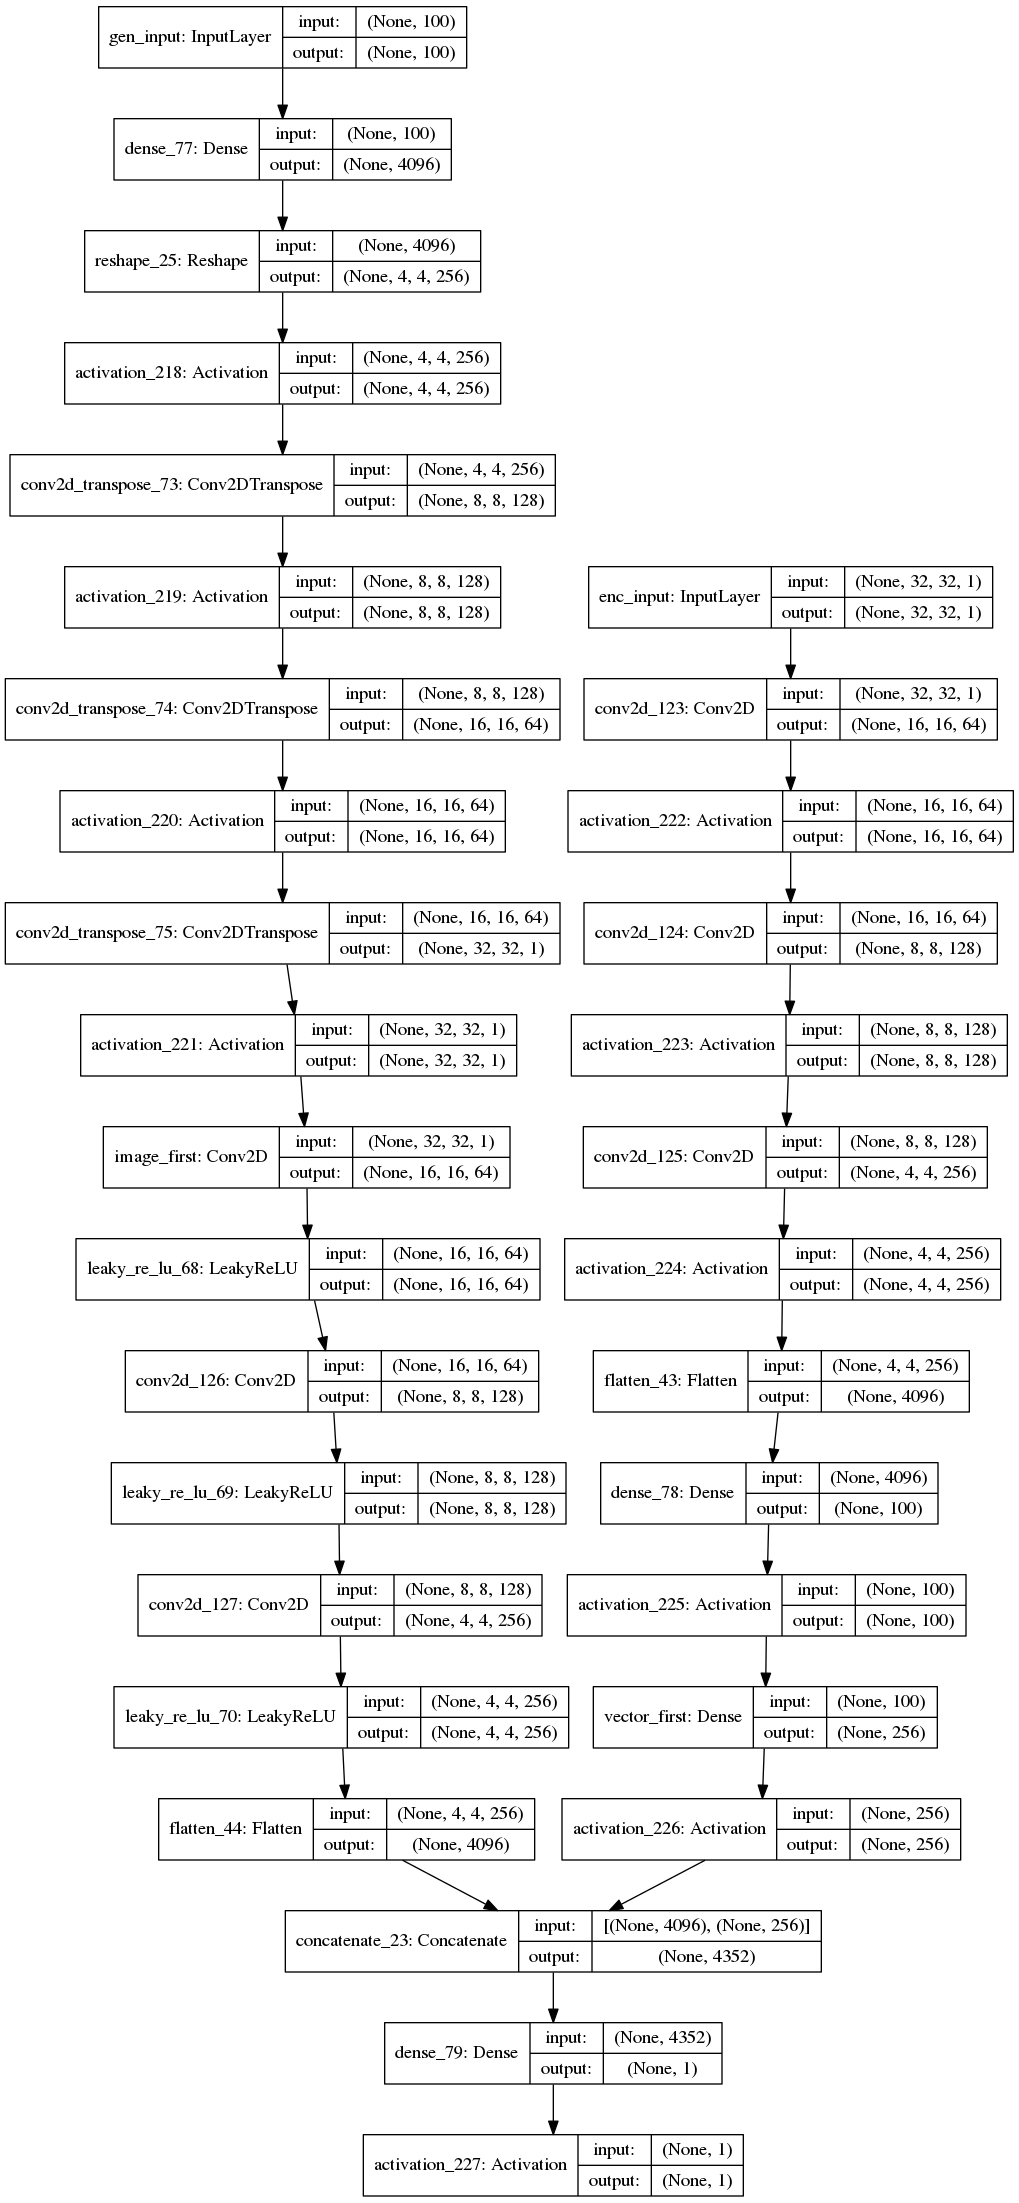

In [234]:
#Image("disc_m.png")
Image("full_m.png")

In [82]:
connect = disc_m.layers[0](gen_m.outputs[0])
m2 = Model(gen_m.input_layers.extend(disc_m.inputs[1]), connect)

TypeError: 'Tensor' object is not iterable.

In [107]:
gen_m.get_layer("gen_input")

In [182]:
import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

tweet_a = Input(shape=(140, 256))
tweet_b = Input(shape=(140, 256))
# This layer can take as input a matrix
# and will return a vector of size 64
shared_lstm = LSTM(64)

# When we reuse the same layer instance
# multiple times, the weights of the layer
# are also being reused
# (it is effectively *the same* layer)
encoded_a = shared_lstm(tweet_a)
encoded_b = shared_lstm(tweet_b)

# We can then concatenate the two vectors:
merged_vector = keras.layers.concatenate([encoded_a, encoded_b], axis=-1)

# And add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(merged_vector)

# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=[tweet_a, tweet_b], outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [184]:
plot_model(model)

In [189]:
encoded_b.device

''

In [30]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [68]:
a = K._to_tensor(np.arange(30), "float32")
b = a ** 2
out2 = tf.gather(b, tf.transpose(tf.where(b > 10)))
print(session.run(out2))
session.run(b)

[[  16.   25.   36.   49.   64.   81.  100.  121.  144.  169.  196.  225.
   256.  289.  324.  361.  400.  441.  484.  529.  576.  625.  676.  729.
   784.  841.]]


array([   0.,    1.,    4.,    9.,   16.,   25.,   36.,   49.,   64.,
         81.,  100.,  121.,  144.,  169.,  196.,  225.,  256.,  289.,
        324.,  361.,  400.,  441.,  484.,  529.,  576.,  625.,  676.,
        729.,  784.,  841.], dtype=float32)